# Keras-OCR

In [1]:
import numpy as np
import keras_ocr
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
def preprocess_image(image_path):
    """
    Improved preprocessing: less aggressive filtering.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Cannot load image: {image_path}")

    # Convert to RGB (keras-ocr expects color images)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Use CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Light denoising instead of blurring
    denoised = cv2.fastNlMeansDenoising(enhanced, h=10)

    # Adaptive threshold (less aggressive)
    binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 10)

    # Convert back to RGB for keras-ocr
    processed = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)

    return processed

In [ ]:
image = preprocess_image("./images/Triparty.pdf_page_9.png")
url = ["./images/Triparty.pdf_page_9.png"]
images = [ keras_ocr.tools.read(i) for i in url]
images.append(image)

In [4]:
pipeline = keras_ocr.pipeline.Pipeline()
kerasocr_preds = pipeline.recognize(images)

Looking for C:\Users\julie\.keras-ocr\craft_mlt_25k.h5

Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.

Looking for C:\Users\julie\.keras-ocr\crnn_kurapan.h5
10/10 [==============================] - 32s 1s/step


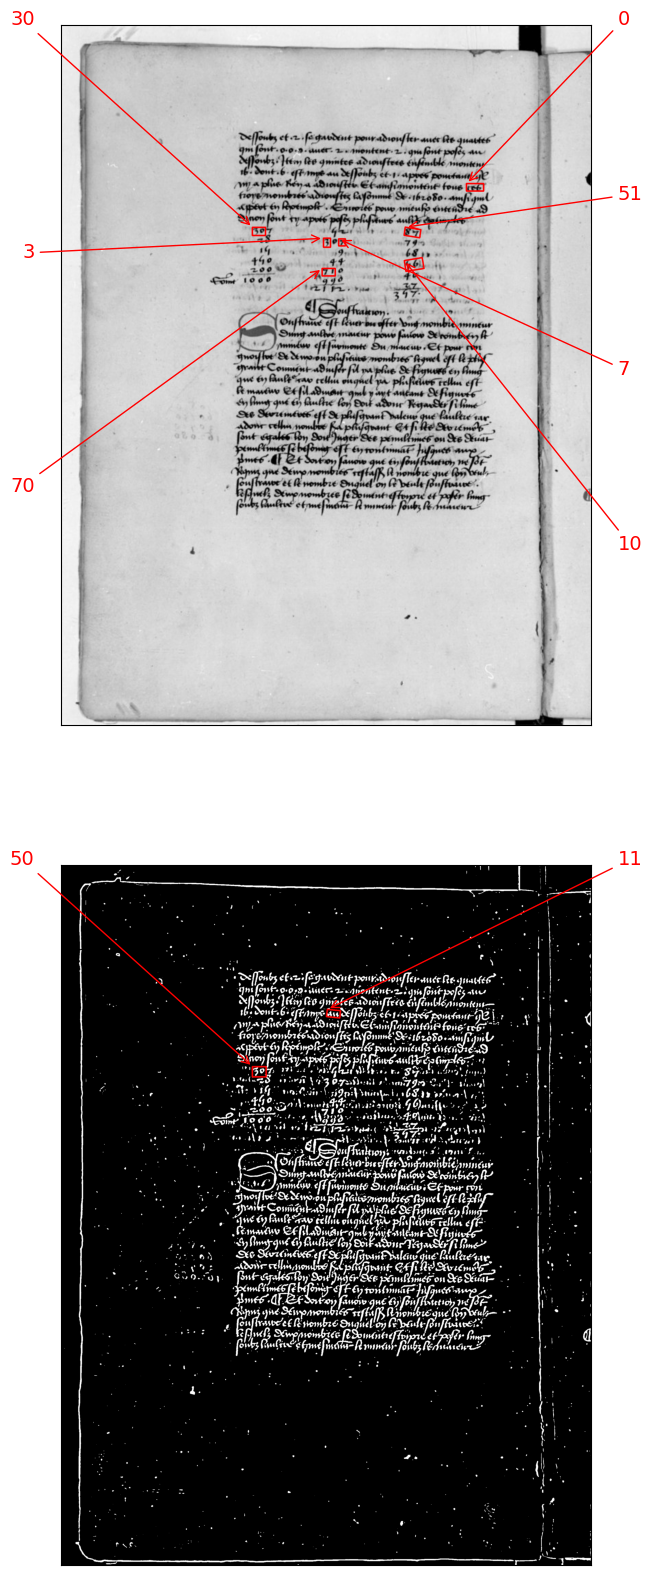

In [5]:
import re
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))

if len(images) == 1:
    axs = [axs]

for ax, image, predictions in zip(axs, images, kerasocr_preds):
    # Filter predictions to keep only numbers
    number_predictions = [(text, box) for text, box in predictions if re.fullmatch(r'\d+', text)]

    # Draw only number annotations
    keras_ocr.tools.drawAnnotations(image=image, predictions=number_predictions, ax=ax)

plt.show()

# Tests with a pretrained CNN on MNIST database

In [6]:
import os
import xml.etree.ElementTree as ET

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.io import loadmat
from keras.utils import to_categorical
import itertools
from scipy.io import loadmat

import warnings
warnings.simplefilter('ignore')

In [7]:
def extract_digits_from_xml(xml_path, image_path):
    # Define the namespace for ALTO
    NS = {'alto': 'http://www.loc.gov/standards/alto/ns-v4#'}

    tree = ET.parse(xml_path)
    root = tree.getroot()

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    digits = []

    # Find all TextBlocks using the namespace
    for textblock in root.findall(".//alto:TextBlock", NS):
        tagrefs = textblock.get("TAGREFS", "")
        if "BT15549" in tagrefs:  # 'chiffre'
            try:
                x = int(textblock.attrib['HPOS'])
                y = int(textblock.attrib['VPOS'])
                w = int(textblock.attrib['WIDTH'])
                h = int(textblock.attrib['HEIGHT'])

                digit_crop = img[y:y+h, x:x+w]
                digit_resized = cv2.resize(digit_crop, (28, 28))
                digit_normalized = digit_resized / 255.0
                digit_normalized = digit_normalized.reshape(28, 28, 1)

                digits.append(digit_normalized)
            except Exception as e:
                print(f"Skipping block due to error: {e}")

    return np.array(digits)

In [8]:
!wget https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat

--2025-04-14 22:14:29--  https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/amplab/datascience-sp14/master/lab7/mldata/mnist-original.mat [following]
--2025-04-14 22:14:30--  https://raw.githubusercontent.com/amplab/datascience-sp14/master/lab7/mldata/mnist-original.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55440440 (53M) [application/octet-stream]
Saving to: 'mnist-original.mat'

     0K .......... .......... .......... .......... ..........  0% 6,04M 9s
    50K .......... .......... ....

In [9]:
def load_mnist_dataset():
    """
    Load MNIST-original dataset

    Returns:
    - mnist_data -- an array of arrays in the shape of (784,)
    - mnist_label -- an array of labels
    - classes -- array of labels classes(a set of labels)
    - shape -- shape of data item
    - channels_count -- channel count of data images
    """

    mnist = loadmat("./mnist-original.mat")
    mnist_data = mnist["data"].T
    mnist_data = mnist_data.reshape(len(mnist_data), 28, 28, 1)
    mnist_label = mnist["label"][0]
    count = len(set(mnist_label))
    return mnist_data, mnist_label, count, (28, 28, 1)

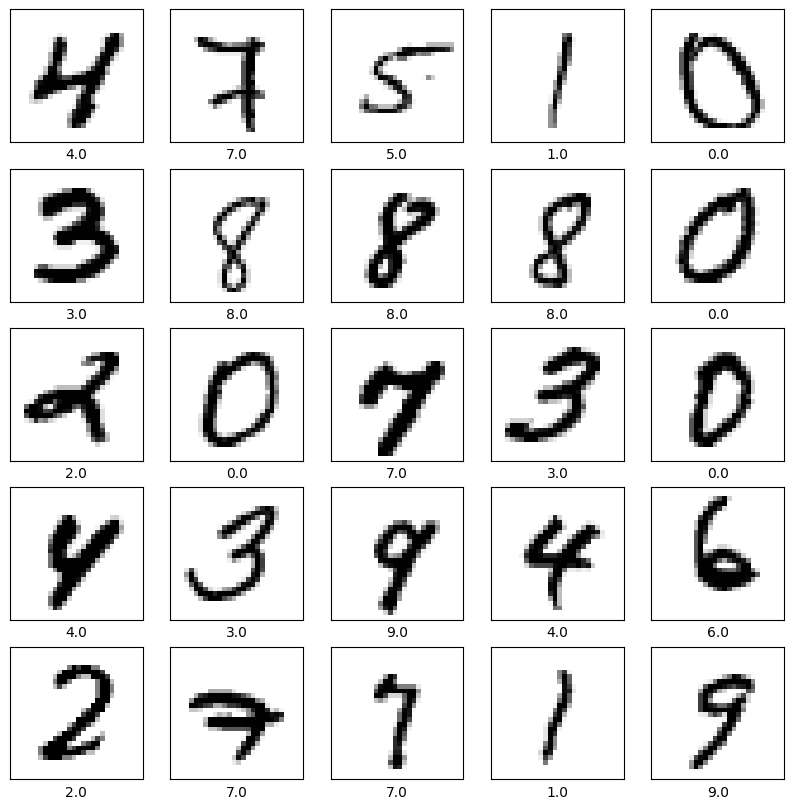

In [10]:
data, labels, classes_count, data_shape = load_mnist_dataset()
def plot_images_sample(X, Y):
    # Draw plot for images sample

    plt.figure(figsize=(10,10))
    rand_indicies = np.random.randint(len(X), size=25)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        index = rand_indicies[i]
        plt.imshow(np.squeeze(X[index]), cmap=plt.cm.binary)
        plt.xlabel(Y[index])
    plt.show()
plot_images_sample(data, labels)

In [11]:
def fe_data(df, target):
    # FE: scaling data ant transform target to categorical
    df = df / 255.
    target = to_categorical(target)
    return df, target

In [12]:
# FE and data splitting
test_size_part = 0.1
x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(data, labels, test_size=test_size_part, shuffle=True)
X_train, Y_train = fe_data(x_train_orig, y_train_orig)
X_test, Y_test = fe_data(x_test_orig, y_test_orig)

In [13]:
model = models.Sequential([
        layers.Conv2D(8, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu', input_shape=data_shape),
        layers.MaxPooling2D((8, 8), padding='same'),
        layers.Conv2D(16, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'),
        layers.MaxPooling2D((4, 4), padding='same'),
        layers.Flatten(),
        layers.Dense(classes_count)
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         136       
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 8)           0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 16)          528       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 16)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                1

In [14]:
# Model training
epochs_num = 10
validation_split_part = 0.2
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=epochs_num, validation_split=validation_split_part)

Epoch 1/10


1575/1575 [==============================] - 9s 3ms/step - loss: 1.0915 - accuracy: 0.6730 - val_loss: 0.5314 - val_accuracy: 0.8501
Epoch 2/10
1575/1575 [==============================] - 5s 3ms/step - loss: 0.4201 - accuracy: 0.8757 - val_loss: 0.3304 - val_accuracy: 0.9083
Epoch 3/10
1575/1575 [==============================] - 5s 3ms/step - loss: 0.3045 - accuracy: 0.9094 - val_loss: 0.2603 - val_accuracy: 0.9248
Epoch 4/10
1575/1575 [==============================] - 5s 3ms/step - loss: 0.2571 - accuracy: 0.9230 - val_loss: 0.2415 - val_accuracy: 0.9294
Epoch 5/10
1575/1575 [==============================] - 5s 3ms/step - loss: 0.2300 - accuracy: 0.9303 - val_loss: 0.2178 - val_accuracy: 0.9348
Epoch 6/10
1575/1575 [==============================] - 5s 3ms/step - loss: 0.2100 - accuracy: 0.9359 - val_loss: 0.2005 - val_accuracy: 0.9395
Epoch 7/10
1575/1575 [==============================] - 5s 3ms/step - loss: 0.1955 - accuracy: 0.9392 - val_loss: 0.1812 - val_accurac

In [15]:
# Print test prediction accuracy
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print("test accuracy: " + str(test_acc))

219/219 - 0s - loss: 0.1520 - accuracy: 0.9544 - 438ms/epoch - 2ms/step
test accuracy: 0.9544285535812378


In [16]:
def get_predictions(X_test):
    # Digits prediction

    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)

    return predictions

In [17]:
def show_predictions_on_image(image_path, predictions, xml_path):
    import xml.etree.ElementTree as ET

    # Load original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Namespace for ALTO
    NS = {'alto': 'http://www.loc.gov/standards/alto/ns-v4#'}

    # Parse XML again for coordinates
    tree = ET.parse(xml_path)
    root = tree.getroot()

    index = 0
    for textblock in root.findall(".//alto:TextBlock", NS):
        tagrefs = textblock.get("TAGREFS", "")
        if "BT15549" in tagrefs:
            try:
                x = int(textblock.attrib['HPOS'])
                y = int(textblock.attrib['VPOS'])
                w = int(textblock.attrib['WIDTH'])
                h = int(textblock.attrib['HEIGHT'])

                # Draw bounding box
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # Put prediction label
                cv2.putText(img, str(predictions[index]), (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                index += 1
            except Exception as e:
                print(f"Skipping box due to error: {e}")

    # Show the image with predictions
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 63ms/step


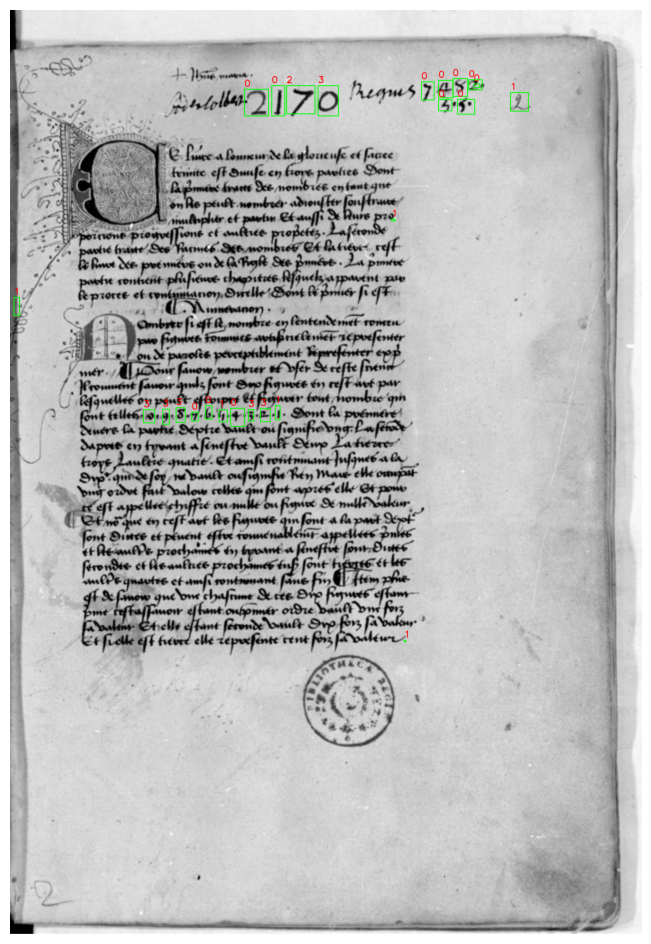

In [ ]:
digits = extract_digits_from_xml("./images/Triparty.pdf_page_6.xml", "./images/Triparty.pdf_page_6.png")
predictions = get_predictions(digits)
show_predictions_on_image("./images/Triparty.pdf_page_6.png", predictions, "./images/Triparty.pdf_page_6.xml")

It seems the predictions of the model are random and the model doesn't recognize our numbers even though they look quite similar to the MNIST database. This may be due to the noise in our manuscripts (ink marks, color of the page...)

Fine tuning the model with instances of the number 2 in our manuscripts

Now, to improve the pre-trained model to be performant on our manuscripts, we'll have to 'show' the model exemples of our numbers so it can learn to recognize and predict them. We'll use the XML files of the corresponding manuscripts, that give the coordinates of the annotated numbers. Let's display each box of coordinates with an index to select them easily:

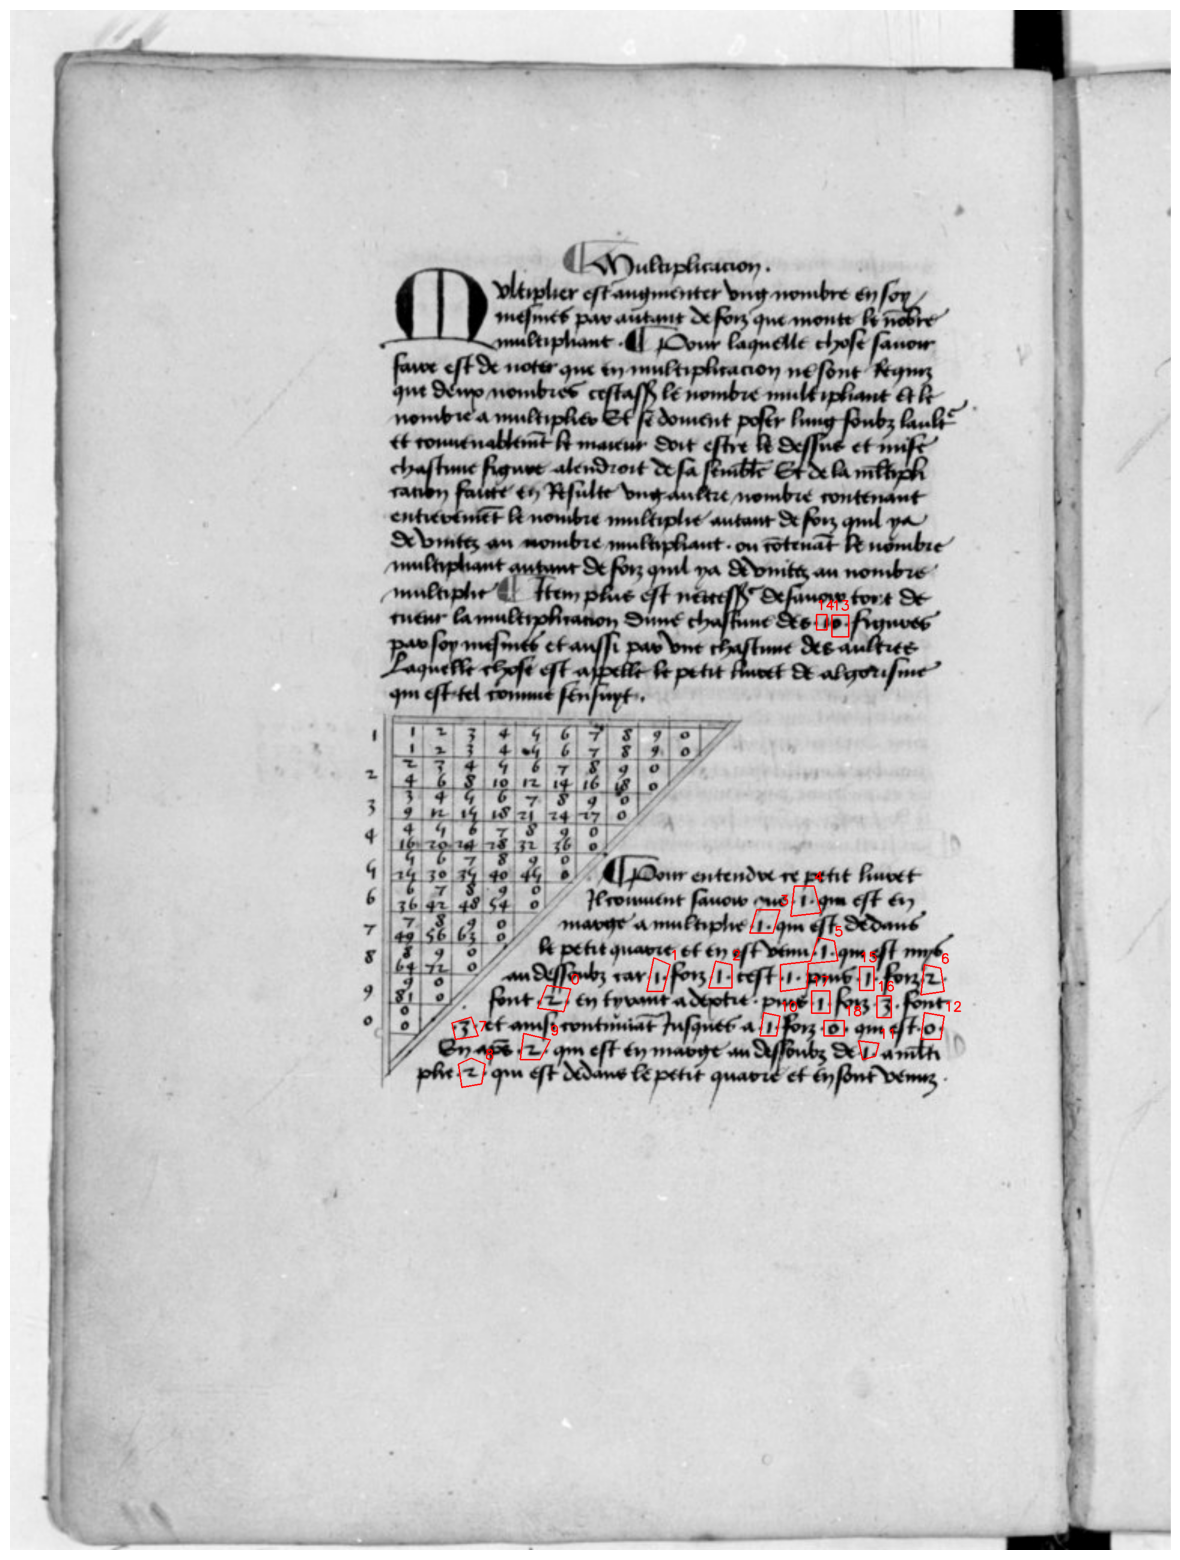

In [21]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load and parse the XML file
xml_file = './images/Triparty.pdf_page_11.xml'
tree = ET.parse(xml_file)
root = tree.getroot()

# Namespace for ALTO XML
namespace = {'alto': 'http://www.loc.gov/standards/alto/ns-v4#'}

# Extract coordinates of text blocks tagged as numbers
number_coordinates = []
for text_block in root.findall('.//alto:TextBlock[@TAGREFS="BT15549"]', namespace):
    polygon = text_block.find('.//alto:Polygon', namespace)
    points = polygon.get('POINTS').split()
    coordinates = [tuple(map(int, point.split(','))) for point in points]
    number_coordinates.append(coordinates)

# Load the image
image_path = './images/Triparty.pdf_page_11.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw bounding boxes on the image
for idx, coords in enumerate(number_coordinates):
    coords_array = np.array(coords, np.int32)
    coords_array = coords_array.reshape((-1, 1, 2))
    cv2.polylines(image_rgb, [coords_array], isClosed=True, color=(255, 0, 0), thickness=2)
    # Add a label (index) next to each bounding box for reference
    x, y = coords_array[0][0]
    cv2.putText(image_rgb, str(idx), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Display the image with bounding boxes
plt.figure(figsize=(20, 20))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Now we can select manually box of coordinates to select the numbers that we want and manually label them. For example, we can tell that the number in the box of index 0 is a 2. We'll start by labelling numbers with the value of 2, so in our manuscripts we can select multiple coordinates and make a json file to regroup them.

In [23]:
def get_textblock_and_coordinates_by_index(xml_file, index):
    # Load and parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Namespace for ALTO XML
    namespace = {'alto': 'http://www.loc.gov/standards/alto/ns-v4#'}

    # Extract TextBlock elements
    textblocks = root.findall('.//alto:TextBlock', namespace)

    # List to store textblock info along with coordinates
    textblock_data = []

    # Loop through each TextBlock and extract the relevant information
    for textblock in textblocks:
        # Get TextBlock attributes and convert them to integers
        hpos = int(textblock.get('HPOS')) if textblock.get('HPOS') is not None else None
        vpos = int(textblock.get('VPOS')) if textblock.get('VPOS') is not None else None
        width = int(textblock.get('WIDTH')) if textblock.get('WIDTH') is not None else None
        height = int(textblock.get('HEIGHT')) if textblock.get('HEIGHT') is not None else None
        textblock_id = textblock.get('ID')
        tagrefs = textblock.get('TAGREFS')

        # Extract coordinates from Polygon element
        polygon = textblock.find('.//alto:Shape/alto:Polygon', namespace)
        if polygon is not None:
            points = polygon.get('POINTS').split()
            coordinates = [(int(points[i]), int(points[i + 1])) for i in range(0, len(points), 2)]
        else:
            coordinates = []

        # Store the data (TextBlock info + coordinates)
        textblock_data.append({
            'hpos': hpos,
            'vpos': vpos,
            'width': width,
            'height': height,
            'polygon': coordinates
        })

    # Check if the index is within the range of available TextBlocks
    if index < 0 or index >= len(textblock_data):
        return f"Invalid index. Please enter an index between 0 and {len(textblock_data) - 1}."

    # Return the TextBlock info and coordinates for the specified index
    return textblock_data[index]


xml_file = './images/Triparty.pdf_page_11.xml'
index = 0  # Specify the index you want the coordinates for
data = get_textblock_and_coordinates_by_index(xml_file, index)

# Print the result
print(f"TextBlock and Coordinates for index {index}:")
print(data)

TextBlock and Coordinates for index 0:
{'hpos': 1066, 'vpos': 1972, 'width': 67, 'height': 53, 'polygon': [(1133, 1979), (1119, 2025), (1066, 2018), (1085, 1972)]}


This function gives us the coordinate for the index that we choose. We can then see all the indexed boxes and select the ones that correspond to the number 2. Then, we can create our own json file by grouping all coordinates. We can do this operation with multiple pages, each page will have a json file. After creating the files:

In [24]:
import json

def load_json(file_path):
    """Load JSON file containing bounding boxes."""
    with open(file_path, 'r') as f:
        return json.load(f)

In [25]:
def prepare_data(json_data, image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cropped_images = []
    labels = []

    for item in json_data:
        x, y, w, h = item['hpos'], item['vpos'], item['width'], item['height']
        digit = img[y:y+h, x:x+w]
        digit = cv2.resize(digit, (28, 28))
        digit = digit / 255.0
        digit = digit.reshape(28, 28, 1)
        cropped_images.append(digit)
        labels.append(2)  # Label "2" as digit

    return np.array(cropped_images), np.array(labels)

We'll give the instances of the number 2 in the selected pages of manuscripts, while keeping instances of 2 from the MNIST database:

In [27]:
from tensorflow.keras.optimizers import Adam

json_files = {
    "./images/Triparty9.json": "./images/Triparty.pdf_page_9.png",
    "./images/Triparty26.json": "./images/Triparty.pdf_page_26.png",
    "./images/Triparty11.json": "./images/Triparty.pdf_page_11.png"
}

manuscript_X, manuscript_y = [], []

for json_file, img_path in json_files.items():
    json_data = load_json(json_file)
    X, y = prepare_data(json_data, img_path)
    manuscript_X.append(X)
    manuscript_y.append(y)

manuscript_X = np.concatenate(manuscript_X, axis=0)
manuscript_y = np.concatenate(manuscript_y, axis=0)

# Get the 2s from MNIST data
mnist_2_indices = np.where(y_train_orig == 2)[0]
mnist_2_samples = x_train_orig[mnist_2_indices]
mnist_2_labels = y_train_orig[mnist_2_indices]

# Combine the "2"s from MNIST and the manuscript "2"s for fine-tuning
X_finetune = np.concatenate((mnist_2_samples, manuscript_X), axis=0)
y_finetune = np.concatenate((mnist_2_labels, manuscript_y), axis=0)

# Make sure the model's layers are frozen except for the last Conv + Dense
for layer in model.layers[:-2]:  # Freeze everything except last Conv + Dense
    layer.trainable = False

# One-hot encode the labels
y_finetune_cat = to_categorical(y_finetune, num_classes=10)

# Compile the model with a lower learning rate for fine-tuning
optimizer = Adam(learning_rate=1e-4)  # Lower learning rate for fine-tuning
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fine-tune the model with the dataset
history = model.fit(X_finetune, y_finetune_cat, epochs=5, batch_size=32, validation_split=0.2)

# Save the fine-tuned model
model.save("finetuned_model_on_2s.h5")

Epoch 1/5
158/158 [==============================] - 2s 9ms/step - loss: 29.2188 - accuracy: 0.9417 - val_loss: 10.7424 - val_accuracy: 0.9628
Epoch 2/5
158/158 [==============================] - 0s 2ms/step - loss: 10.0522 - accuracy: 0.9788 - val_loss: 3.5986 - val_accuracy: 0.9818
Epoch 3/5
158/158 [==============================] - 0s 2ms/step - loss: 5.6090 - accuracy: 0.9889 - val_loss: 1.2538 - val_accuracy: 0.9897
Epoch 4/5
158/158 [==============================] - 0s 2ms/step - loss: 3.7422 - accuracy: 0.9923 - val_loss: 0.4354 - val_accuracy: 0.9960
Epoch 5/5
158/158 [==============================] - 0s 2ms/step - loss: 2.6214 - accuracy: 0.9943 - val_loss: 0.1419 - val_accuracy: 0.9976


1/1 [==============================] - 0s 78ms/step


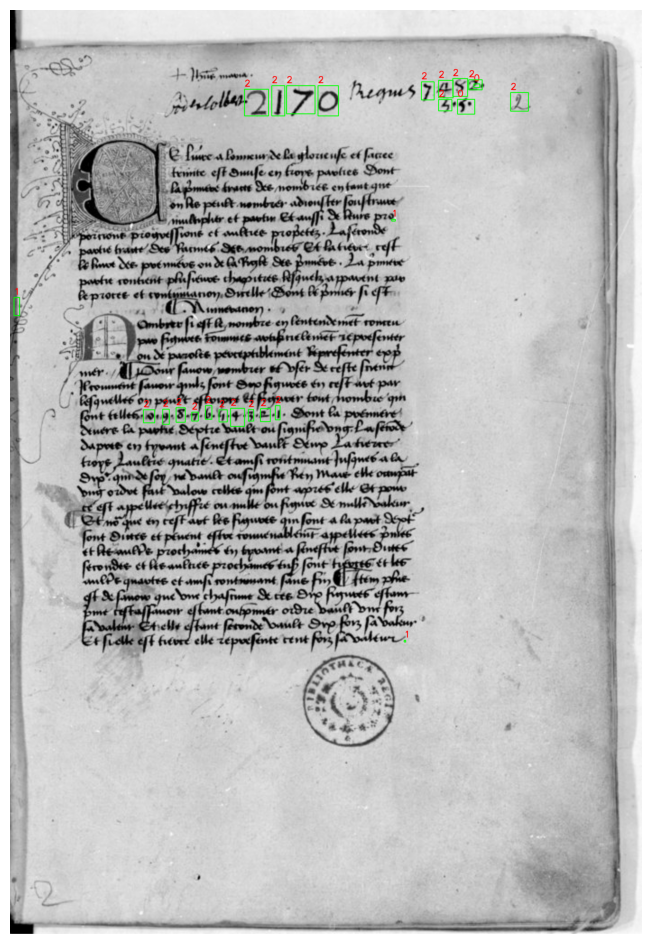

In [28]:
digits = extract_digits_from_xml("./images/Triparty.pdf_page_6.xml", "./images/Triparty.pdf_page_6.png")
predictions = get_predictions(digits)
show_predictions_on_image("./images/Triparty.pdf_page_6.png", predictions, "./images/Triparty.pdf_page_6.xml")

Because we only gave the model instances of the umber 2, it's become biased and recognizes every number as a 2 because the classes are imbalanced. To solve this problem and still fine tune the model to our numbers, we should give multiple instances of all numbers (from 0 to 9) to the model so it may not become biased on one number.